In [2]:
from __future__ import division, print_function
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
%matplotlib nbagg
%matplotlib inline 
import numpy as np
import sklearn.datasets
import theano
import theano.tensor as T
import lasagne
import math

# Variational Auto-encoders and Semi-supervised Learning

Now we are going to extend the VAE from lab52 with a variable $y$, so that we can apply supervised and semi-supervised learning. We'll model the supervised VAE in which we model $p(x|y,z)$ and $q(z|x,y)$ (cf. [Kingma et al.](https://arxiv.org/abs/1406.5298)). This way we condition our latent variable and our generated sample on our label $y$. Next we'll define semi-supervised learning in which $y$ is given for the labeled data and as a latent variable that is marginalized out for the unlabeled data.

## MNIST: Supervised VAE
First we'll load the MNIST dataset and plot a few examples. We only load a limited amount of number classes, so that we can speed up training.

In [4]:
from sklearn.utils import shuffle
#To speed up training we'll only work on a subset of the data
#We discretize the data to 0 and 1 in order to use it with a bernoulli observation model p(x|z) = Ber(mu(z))

def bernoullisample(x):
    return np.random.binomial(1,x,size=x.shape).astype(theano.config.floatX)

def onehot(t, num_classes):
    out = np.zeros((t.shape[0], num_classes)).astype('float32')
    for row, col in enumerate(t):
        out[row, col] = 1
    return out

data = np.load('../week1/mnist.npz')
num_classes = 3
idxs_train = []
idxs_valid = []
idxs_test = []
for i in range(num_classes):
    idxs_train += np.where(data['y_train'] == i)[0].tolist()
    idxs_valid += np.where(data['y_valid'] == i)[0].tolist()
    idxs_test += np.where(data['y_test'] == i)[0].tolist()

x_train = bernoullisample(data['X_train'][idxs_train]).astype('float32')
targets_train = data['y_train'][idxs_train].astype('int32') # Since this is unsupervised, the targets are only used for validation.
x_train, targets_train = shuffle(x_train, targets_train, random_state=1234)
t_train = onehot(targets_train, num_classes)

x_valid = bernoullisample(data['X_valid'][idxs_valid]).astype('float32')
targets_valid = data['y_valid'][idxs_valid].astype('int32')
t_valid = onehot(targets_valid, num_classes)

x_test = bernoullisample(data['X_test'][idxs_test]).astype('float32')
targets_test = data['y_test'][idxs_test].astype('int32')
t_test = onehot(targets_test, num_classes)

print("training set dim(%i, %i)." % x_train.shape)
print("validation set dim(%i, %i)." % x_valid.shape)
print("test set dim(%i, %i)." % x_test.shape)

training set dim(15578, 784).
validation set dim(3045, 784).
test set dim(3147, 784).


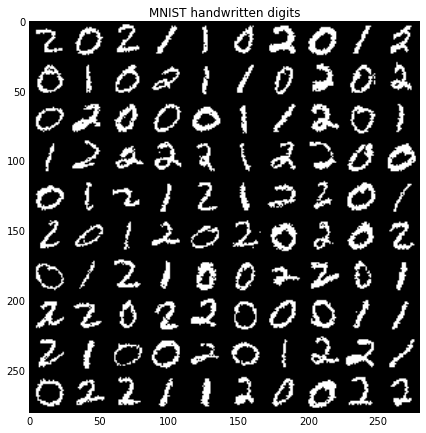

In [5]:
#plot a few MNIST examples
def plot_samples(x,title=''):
    idx = 0
    canvas = np.zeros((28*10, 10*28))
    for i in range(10):
        for j in range(10):
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_train[idx].reshape((28, 28))
            idx += 1
    plt.figure(figsize=(7, 7))
    plt.imshow(canvas, cmap='gray')
    plt.title(title)
    plt.show()

plot_samples(x_train[:100],title='MNIST handwritten digits')

As for lab3, we define the helper functions for calculating the lowerbound.

In [6]:
#defined a couple of helper functions
c = - 0.5 * math.log(2*math.pi)
def log_bernoulli(x, p, eps=0.0):
    p = T.clip(p, eps, 1.0 - eps)
    return -T.nnet.binary_crossentropy(p, x)

def kl_normal2_stdnormal(mean, log_var):
    return -0.5*(1 + log_var - mean**2 - T.exp(log_var))

The model should now be modified to condition on the labeled data $y$.

In [7]:
from lasagne.layers import InputLayer, DenseLayer, get_output, get_all_params, ConcatLayer
from lasagne.nonlinearities import rectify, sigmoid
from samplelayer import SimpleSampleLayer

num_features = x_train.shape[-1]
num_latent_z = 2

#MODEL SPECIFICATION

#ENCODER
l_in_x = InputLayer(shape=(None, num_features))
l_in_y = InputLayer(shape=(None, num_classes))
l_enc = ConcatLayer([l_in_x, l_in_y])
l_enc = DenseLayer(l_enc, num_units=128, nonlinearity=rectify)
l_muq = DenseLayer(l_enc, num_units=num_latent_z, nonlinearity=None)     #mu(x)
l_logvarq = DenseLayer(l_enc, num_units=num_latent_z, nonlinearity=lambda x: T.clip(x,-10,10)) #logvar(x), 
l_z = SimpleSampleLayer(mean=l_muq, log_var=l_logvarq) #sample a latent representation z \sim q(z|x) = N(mu(x),logvar(x))
#we split the in two parts to allow sampling from the decoder model separately
#DECODER
l_in_z = InputLayer(shape=(None, num_latent_z))
l_dec = ConcatLayer([l_in_z, l_in_y])
l_dec = DenseLayer(l_dec, num_units=128, nonlinearity=rectify) 
l_mux = DenseLayer(l_dec, num_units=num_features, nonlinearity=sigmoid)  #reconstruction of input using a sigmoid output since mux \in [0,1] 

The objective functions are defined similarly to lab52.

In [8]:

sym_x = T.matrix('x')
sym_y = T.matrix('y')
sym_z = T.matrix('z')

z_train, muq_train, logvarq_train = get_output([l_z,l_muq,l_logvarq],{l_in_x:sym_x, l_in_y:sym_y},deterministic=False)
mux_train = get_output(l_mux,{l_in_z:z_train, l_in_y:sym_y},deterministic=False)

z_eval, muq_eval, logvarq_eval = get_output([l_z,l_muq,l_logvarq],{l_in_x:sym_x, l_in_y:sym_y},deterministic=True)
mux_eval = get_output(l_mux,{l_in_z:z_eval, l_in_y:sym_y},deterministic=True)

mux_sample = get_output(l_mux,{l_in_z:sym_z, l_in_y:sym_y},deterministic=True)

#define the cost function
def LogLikelihood(mux,x,muq,logvarq):
    log_px_given_z = log_bernoulli(x, mux, eps=1e-6).sum(axis=1).mean() #note that we sum the latent dimension and mean over the samples
    KL_qp = kl_normal2_stdnormal(muq, logvarq).sum(axis=1).mean()
    LL = log_px_given_z - KL_qp
    return LL, log_px_given_z, KL_qp

LL_train, logpx_train, KL_train = LogLikelihood(mux_train, sym_x, muq_train, logvarq_train)
LL_eval, logpx_eval, KL_eval = LogLikelihood(mux_eval, sym_x, muq_eval, logvarq_eval)

all_params = get_all_params([l_z,l_mux],trainable=True)

# Let Theano do its magic and get all the gradients we need for training
all_grads = T.grad(-LL_train, all_params)

# Set the update function for parameters. The Adam optimizer works really well with VAEs.
updates = lasagne.updates.adam(all_grads, all_params, learning_rate=1e-3)

f_train = theano.function(inputs=[sym_x, sym_y],
                          outputs=[LL_train, logpx_train, KL_train],
                          updates=updates)

f_eval = theano.function(inputs=[sym_x, sym_y],
                         outputs=[LL_eval, logpx_eval, KL_eval])

f_z = theano.function(inputs=[sym_x, sym_y],
                         outputs=[z_eval])

f_sample = theano.function(inputs=[sym_z, sym_y],
                         outputs=[mux_sample])

f_recon = theano.function(inputs=[sym_x, sym_y],
                         outputs=[mux_eval])

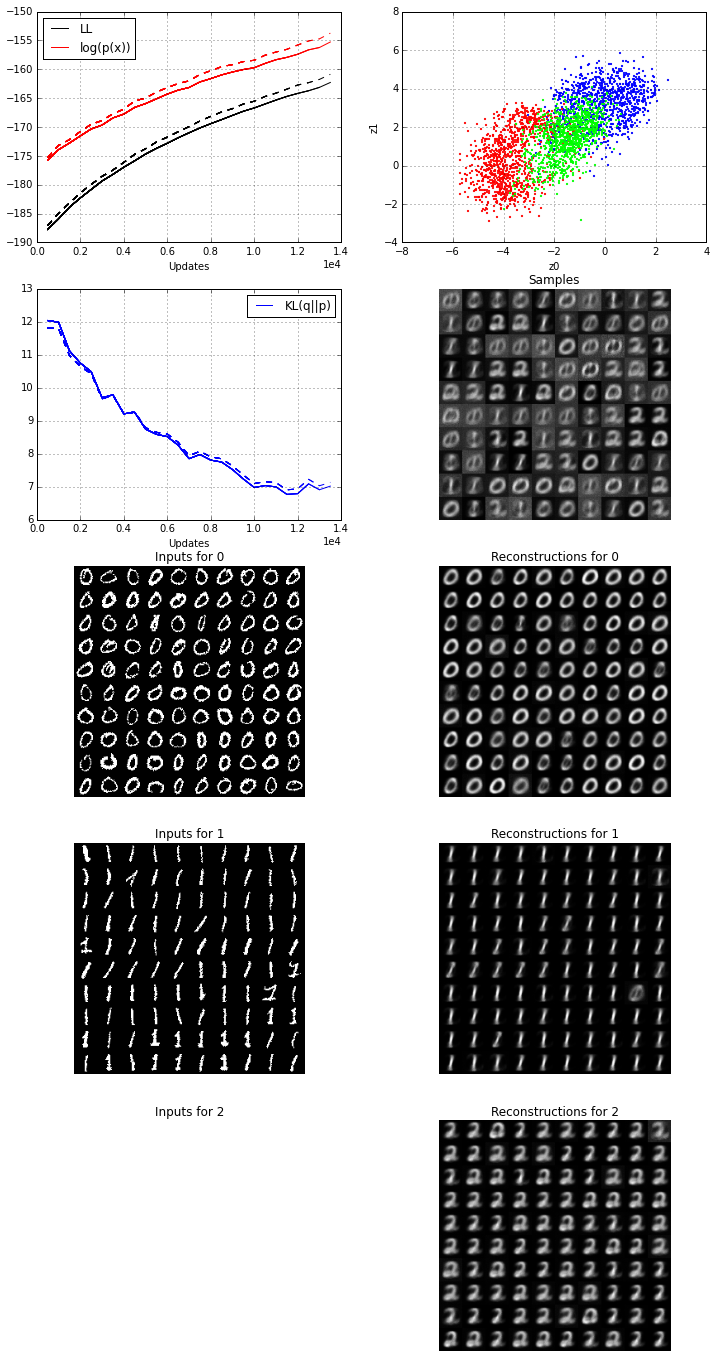

In [10]:
batch_size = 100
samples_to_process = 1e4
val_interval = 5e2
 
LL_train, KL_train, logpx_train = [],[],[]
LL_valid, KL_valid, logpx_valid = [],[],[]
samples_processed = 0
plt.figure(figsize=(12, 24))
valid_samples_processed = []

try:
    while samples_processed < samples_to_process:
        _LL_train, _KL_train, _logpx_train = [],[],[]
        idxs = np.random.choice(range(x_train.shape[0]), size=(batch_size), replace=False)  
        x_batch = x_train[idxs]
        t_batch = t_train[idxs]
        out = f_train(x_batch, t_batch)
        samples_processed += batch_size
           
        if samples_processed % val_interval == 0:
            valid_samples_processed += [samples_processed]
            out = f_eval(x_train, t_train)
            LL_train += [out[0]] 
            logpx_train += [out[1]]
            KL_train += [out[2]]
            
            out = f_eval(x_valid, t_valid)
            LL_valid += [out[0]]
            logpx_valid += [out[1]]
            KL_valid += [out[2]]
            
            z_eval = f_z(x_valid, t_valid)[0]
            x_sample = f_sample(np.random.normal(size=(100, num_latent_z)).astype('float32'), onehot(np.random.randint(0, num_classes, size=100), num_classes))[0]
            x_recon = f_recon(x_valid, t_valid)[0]
            
            plt.subplot(num_classes+2,2,1)
            plt.legend(['LL', 'log(p(x))'], loc=2)
            plt.xlabel('Updates')
            plt.plot(valid_samples_processed, LL_train, color="black")
            plt.plot(valid_samples_processed, logpx_train, color="red")
            plt.plot(valid_samples_processed, LL_valid, color="black", linestyle="--")
            plt.plot(valid_samples_processed, logpx_valid, color="red", linestyle="--")
            plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
            plt.grid('on')
            
            plt.subplot(num_classes+2,2,2)
            plt.cla()
            plt.xlabel('z0'), plt.ylabel('z1')
            color = iter(plt.get_cmap('brg')(np.linspace(0, 1.0, num_classes)))
            for i in range(num_classes):
                clr = next(color)
                plt.scatter(z_eval[targets_valid==i, 0], z_eval[targets_valid==i, 1], c=clr, s=5., lw=0, marker='o', )
            plt.grid('on')
            
            
            plt.subplot(num_classes+2,2,3)
            plt.legend(['KL(q||p)'])
            plt.xlabel('Updates')
            plt.plot(valid_samples_processed, KL_train, color="blue")
            plt.plot(valid_samples_processed, KL_valid, color="blue", linestyle="--")
            plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
            plt.grid('on')
            
            plt.subplot(num_classes+2,2,4)
            plt.cla()
            plt.title('Samples')
            plt.axis('off')
            idx = 0
            canvas = np.zeros((28*10, 10*28))
            for i in range(10):
                for j in range(10):
                    canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_sample[idx].reshape((28, 28))
                    idx += 1
            plt.imshow(canvas, cmap='gray')
            
            c=0
            for k in range(5, 5 + num_classes*2, 2):
                plt.subplot(num_classes+2,2,k)
                plt.cla()
                plt.title('Inputs for %i' % c)
                plt.axis('off')
                idx = 0
                canvas = np.zeros((28*10, 10*28))
                for i in range(10):
                    for j in range(10):
                        canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_valid[targets_valid==c][idx].reshape((28, 28))
                        idx += 1
                plt.imshow(canvas, cmap='gray')

                plt.subplot(num_classes+2,2,k+1)
                plt.cla()
                plt.title('Reconstructions for %i' % c)
                plt.axis('off')
                idx = 0
                canvas = np.zeros((28*10, 10*28))
                for i in range(10):
                    for j in range(10):
                        canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_recon[targets_valid==c][idx].reshape((28, 28))
                        idx += 1
                plt.imshow(canvas, cmap='gray')
                c += 1
            
            plt.savefig("out53.png")
            display(Image(filename="out53.png"))
            clear_output(wait=True)
            
except KeyboardInterrupt:
    pass



### Exercise 1 - Analyzing the supervised VAE
1. Test different network structures and evaluate the performance of the model.
2. Investigate the latent space $z$ of the supervised VAE by performing a random walk and generating samples in the same way as [Kingma et al.](https://arxiv.org/abs/1406.5298).

## MNIST: Semi-supervised VAE (for the very ambitous)

For the semi-supervised modeling, we generate a labeled subset of our training data.

In [12]:
def bernoullisample(x):
    return np.random.binomial(1,x,size=x.shape).astype(theano.config.floatX)

data = np.load('../week1/mnist.npz')
num_classes = 5
idxs_train = []
idxs_valid = []
idxs_test = []
for i in range(num_classes):
    idxs_train += np.where(data['y_train'] == i)[0].tolist()
    idxs_valid += np.where(data['y_valid'] == i)[0].tolist()
    idxs_test += np.where(data['y_test'] == i)[0].tolist()

x_train = bernoullisample(data['X_train'][idxs_train]).astype('float32')
targets_train = data['y_train'][idxs_train].astype('int32') # Since this is unsupervised, the targets are only used for validation.
x_train, targets_train = shuffle(x_train, targets_train, random_state=1234)
t_train = onehot(targets_train, num_classes)

x_valid = bernoullisample(data['X_valid'][idxs_valid]).astype('float32')
targets_valid = data['y_valid'][idxs_valid].astype('int32')
t_valid = onehot(targets_valid, num_classes)

x_test = bernoullisample(data['X_test'][idxs_test]).astype('float32')
targets_test = data['y_test'][idxs_test].astype('int32')
t_test = onehot(targets_test, num_classes)

print("training set dim(%i, %i)." % x_train.shape)
print("validation set dim(%i, %i)." % x_valid.shape)
print("test set dim(%i, %i)." % x_test.shape)

training set dim(25538, 784).
validation set dim(5058, 784).
test set dim(5139, 784).


labeled training set dim(10, 784).


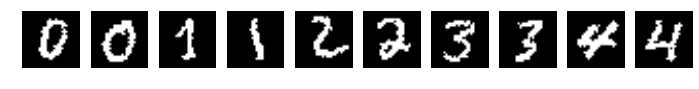

In [13]:
# Generate a subset of labeled data points

num_labeled = 2 # You decide on the size of the fraction...

idxs_train_l = []
for i in range(num_classes):
    idxs = np.where(targets_train == i)[0]
    idxs_train_l += np.random.choice(idxs, size=num_labeled).tolist()

x_train_l = x_train[idxs_train_l]
t_train_l = onehot(targets_train[idxs_train_l], num_classes)
print("labeled training set dim(%i, %i)." % x_train_l.shape)

plt.figure(figsize=(12, 7))
for i in range(num_classes*num_labeled):
    im = x_train_l[i].reshape((28, 28))
    plt.subplot(1, num_classes*num_labeled, i+1)
    plt.imshow(im, cmap='gray')
    plt.axis('off')

For the semi-supervised case, the lower bound is divided into two, so that for the labeled data we have:
$$
\begin{align}
\log p(x,y) &= \int_z \log p(x,y,z) dz \\
&\ge \int_z q(z|x,y) \log \bigg[ \frac{p(x,y,z)}{q(z|x,y)} \bigg]dz \\
&= \mathbb{E}_{q(z|x,y)} [\log p(x,y,z) - \log q(z|x,y)]dz \equiv -\mathcal{L}(x,y)\ ,
\end{align}
$$

where in our case the $p(x,y,z)=p(x|y,z)p(y)p(z)$. For the unlabeled data $y$ is now a latent variable that needs to be marginalized out:
$$
\begin{align}
\log p(x,y) &= \int_y \int_z \log p(x,y,z) dzdy \\
&\ge \int_y q(y|x) \int_z q(z|x,y) \log \bigg[ \frac{p(x,y,z)}{q(y|x)q(z|x,y)} \bigg]dzdy \\
&= \int_y q(y|x) \int_z q(z|x,y) [\log p(x,y,z) - \log q(y|x) - \log q(z|x,y) ]dzdy \\
&= \int_y q(y|x) \int_z q(z|x,y) [\log p(x,y,z) - \log q(z|x,y)]dzdy - \int_y \int_z q(y|x)q(z|x,y) \log q(y|x)dzdy \\
&= \int_y q(y|x) \int_z q(z|x,y) [\log p(x,y,z) - \log q(z|x,y)]dzdy - \int_y q(y|x) \log q(y|x) \int_z q(z|x,y)dzdy \\
&= \int_y q(y|x) \int_z q(z|x,y) [\log p(x,y,z) - \log q(z|x,y)]dzdy - \int_y q(y|x) \log q(y|x)dy \cdot 1 \\
&= \int_y q(y|x) \int_z q(z|x,y) [\log p(x,y,z) - \log q(z|x,y)]dzdy + \mathcal{H}(q(y|x)) \\
&= \sum_y q(y|x) (-\mathcal{L}(x,y)) + \mathcal{H}(q(y|x)) \equiv -\mathcal{U}(x)\ .
\end{align}
$$

We collect the two lowerbounds by:
$$
\begin{align}
\mathcal{J}^\alpha = \sum_{x_l,y_l} \mathcal{L}(x_l, y_l) - \alpha \cdot \log q(y_l|x_l) + \sum_{x_u, y_u} \mathcal{U}(x_u, y_u) \ ,
\end{align}
$$

where the right hand-side is the addition of the cross-entropy scaled by an alpha constant which is equivalent to the fraction between unlabeled and labeled data points.

Following you are provided with a code snippet for computing the lowerbound for the semi-supervised VAE:

In [14]:
from lasagne.layers import InputLayer, DenseLayer, get_output, get_all_params, ConcatLayer
from lasagne.nonlinearities import rectify, sigmoid, softmax
from samplelayer import SimpleSampleLayer

num_features = x_train.shape[-1]
num_latent_z = 16

#MODEL SPECIFICATION
l_in_x = InputLayer(shape=(None, num_features))
l_in_y = InputLayer(shape=(None, num_classes))

#Classifier
l_y = DenseLayer(l_in_x, num_units=128, nonlinearity=rectify)
l_y = DenseLayer(l_y, num_units=num_classes, nonlinearity=softmax)

#ENCODER
l_enc = ConcatLayer([l_in_x, l_in_y])
l_enc = DenseLayer(l_enc, num_units=128, nonlinearity=rectify)
l_muq = DenseLayer(l_enc, num_units=num_latent_z, nonlinearity=None)     #mu(x)
l_logvarq = DenseLayer(l_enc, num_units=num_latent_z, nonlinearity=lambda x: T.clip(x,-10,10)) #logvar(x), 
l_z = SimpleSampleLayer(mean=l_muq, log_var=l_logvarq) #sample a latent representation z \sim q(z|x) = N(mu(x),logvar(x))
#we split the in two parts to allow sampling from the decoder model separately
#DECODER
l_in_z = InputLayer(shape=(None, num_latent_z))
l_dec = ConcatLayer([l_in_z, l_in_y])
l_dec = DenseLayer(l_dec, num_units=128, nonlinearity=rectify)
l_mux = DenseLayer(l_dec, num_units=num_features, nonlinearity=sigmoid)  #reconstruction of input using a sigmoid output since mux \in [0,1] 

In [15]:
from lasagne.objectives import categorical_crossentropy, categorical_accuracy

sym_x_l = T.matrix('x_l')
sym_x = T.matrix('x')
sym_y = T.matrix('y')
sym_z = T.matrix('z')

y_eval = get_output(l_y, {l_in_x:sym_x}, deterministic=True)
z_eval = get_output(l_z,{l_in_x:sym_x, l_in_y:sym_y},deterministic=True)

#define the cost function for labeled data points
y_train_l = get_output(l_y, {l_in_x:sym_x_l}, deterministic=False)
z_train_l, muq_train_l, logvarq_train_l = get_output([l_z,l_muq,l_logvarq],{l_in_x:sym_x_l, l_in_y:sym_y},deterministic=False)
mux_train_l = get_output(l_mux,{l_in_z:z_train_l, l_in_y:sym_y},deterministic=False)

log_px_l = log_bernoulli(sym_x_l, mux_train_l, eps=1e-6).sum(axis=-1)
KL_qp_l = kl_normal2_stdnormal(muq_train_l, logvarq_train_l).sum(axis=-1)
log_qy_l = T.sum(sym_y * T.log(y_train_l+1e-8), axis=1)
py_l = softmax(T.zeros((sym_x_l.shape[0], num_classes)))
log_py_l = -categorical_crossentropy(py_l, sym_y)
alpha = 0.1*(x_train.shape[0]/x_train_l.shape[0])
LL_l_eval = T.mean(log_px_l + log_py_l - KL_qp_l)
LL_l = T.mean(log_px_l + log_py_l - KL_qp_l + alpha * log_qy_l)


#define the cost function for unlabeled data points

# For the integrating out approach, we repeat the input matrix x, and construct a target (bs * n_y) x n_y
# Example of input and target matrix for a 3 class problem and batch_size=2. 2D tensors of the form
#               x_repeat                     t_repeat
#  [[x[0,0], x[0,1], ..., x[0,n_x]]         [[1, 0, 0]
#   [x[1,0], x[1,1], ..., x[1,n_x]]          [1, 0, 0]
#   [x[0,0], x[0,1], ..., x[0,n_x]]          [0, 1, 0]
#   [x[1,0], x[1,1], ..., x[1,n_x]]          [0, 1, 0]
#   [x[0,0], x[0,1], ..., x[0,n_x]]          [0, 0, 1]
#   [x[1,0], x[1,1], ..., x[1,n_x]]]         [0, 0, 1]]
t_eye = T.eye(num_classes, k=0)
t_u = t_eye.reshape((num_classes, 1, num_classes)).repeat(sym_x.shape[0], axis=1).reshape((-1, num_classes))
x_u = sym_x.reshape((1, sym_x.shape[0], sym_x.shape[1])).repeat(num_classes, axis=0).reshape((-1, sym_x.shape[1]))

y_train = get_output(l_y, {l_in_x:sym_x}, deterministic=False)
z_train, muq_train, logvarq_train = get_output([l_z,l_muq,l_logvarq],{l_in_x:x_u, l_in_y:t_u},deterministic=False)
mux_train = get_output(l_mux,{l_in_z:z_train, l_in_y:t_u},deterministic=False)

log_px_given_z_u = log_bernoulli(x_u, mux_train, eps=1e-6).sum(axis=-1)
KL_qp_u = kl_normal2_stdnormal(muq_train, logvarq_train).sum(axis=-1)
py_u = softmax(T.zeros((x_u.shape[0], num_classes)))
log_py_u = -categorical_crossentropy(py_u, t_u)
LL_u = log_px_given_z_u + log_py_u - KL_qp_u
LL_u = LL_u.reshape((num_classes, sym_x.shape[0])).T
LL_u = T.sum(y_train * (LL_u - T.log(y_train+1e-8)), axis=-1).mean()

LL = LL_u + LL_l

eval_acc = categorical_accuracy(y_eval, sym_y).mean()

all_params = get_all_params([l_z,l_mux,l_y],trainable=True)

# Let Theano do its magic and get all the gradients we need for training
all_grads = T.grad(-LL, all_params)

# Set the update function for parameters. The Adam optimizer works really well with VAEs.
updates = lasagne.updates.adam(all_grads, all_params, learning_rate=3e-5)

f_train = theano.function(inputs=[sym_x, sym_x_l, sym_y],
                          outputs=[LL],
                          updates=updates)

f_train_eval = theano.function(inputs=[sym_x, sym_x_l, sym_y],
                          outputs=[LL_l_eval, LL_u, KL_qp_l.mean(), KL_qp_u.mean()])

f_eval = theano.function(inputs=[sym_x, sym_y],
                         outputs=[eval_acc])

f_z = theano.function(inputs=[sym_x, sym_y],
                         outputs=[z_eval])


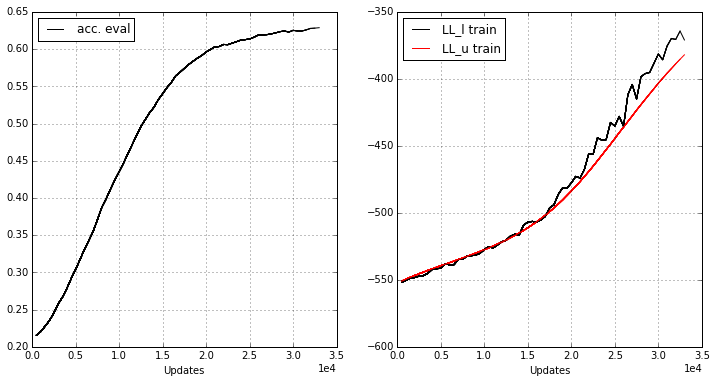

In [16]:
batch_size = 100
samples_to_process = 9e4
val_interval = 5e2
 
LL_l_train, LL_u_train, KL_l_train, KL_u_train = [], [], [], []
acc_valid = []
samples_processed = 0
plt.figure(figsize=(12, 6))
valid_samples_processed = []

try:
    while samples_processed < samples_to_process:
        idxs = np.random.choice(range(x_train.shape[0]), size=(batch_size), replace=False)  
        x_batch = x_train[idxs]
        t_batch = t_train[idxs]
        out = f_train(x_batch, x_train_l, t_train_l)
        samples_processed += batch_size
           
        if samples_processed % val_interval == 0:
            valid_samples_processed += [samples_processed]
            out = f_train_eval(x_train, x_train_l, t_train_l)
            LL_l_train += [out[0]]
            LL_u_train += [out[1]]
            KL_l_train += [out[2]]
            KL_u_train += [out[3]]
            
            out = f_eval(x_valid, t_valid)
            acc_valid += [out[0]]
            
            #z_eval = f_z(x_valid, t_valid)[0]
            
            plt.subplot(1, 2, 1)
            plt.legend(['acc. eval'], loc=2)
            plt.xlabel('Updates')
            plt.plot(valid_samples_processed, acc_valid, color="black")
            plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
            plt.grid('on')
            
            plt.subplot(1, 2, 2)
            plt.legend(['LL_l train', 'LL_u train'], loc=2)
            plt.xlabel('Updates')
            plt.plot(valid_samples_processed, LL_l_train, color="black")
            plt.plot(valid_samples_processed, LL_u_train, color="red")
            plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
            plt.grid('on')
            
            
            
            plt.savefig("out53.png")
            display(Image(filename="out53.png"))
            clear_output(wait=True)
            
        
except KeyboardInterrupt:
    pass




### Exercise 2 - Analyzing the semi-supervised VAE
1. Understand how the above code works.
2. Test different network structures and fractions of labeled/unlabeled data and evaluate the performance of the model.
3. What happens when you remove the labeled lowerbound from the objective.
4. What does the scaling of the labeled cross-entropy do to the training.
3. Try to benchmark this model against other semi-supervised approaches.